# A Computational Investigation of Magnetic Dampening in Guitar Strings

##  Introduction 

A modern electric guitar uses ferromagnetic Nickel strings whose vibration is converted into an electrical signal via a “pickup”. The basic idea of a guitar pickup is a magnet inside a coil of wire that generates current corresponding to a magnetic string perturbing its field.<br>
Multiple variations of these pickups exist, featuring different magnet sizes and strengths as well as coil winding patterns. Some pickups utilize specific patterns and materials with the direct intention of altering sound signatures by manipulating the magnetic field of its magnets.While Hum-buckers, Soapbar-pickups, p90's, and many more offer different coil counts and sizes, each advertising different sounds, our main interest will be the simple single-coil. Single-coil pickups usually feature 6 aluminum-nickel-cobalt slugs surrounded by a single coil of wires, and are commonly referred to alnico single-coils or simply single-coils

The vast majority of electric guitars come equipped with multiple pickups that can be toggled on and off. With the assumption that turning a pickup off will allow different tones to be explored without affecting the overall system, many musicians opt for multi-pickup configurations in the name of versatility. However, there is a small leaning in the guitar community that tend toward guitars with only one pickup, believing the guitars to produce superior and less-altered sounds than their multi-pickup counterparts.<br>
The aim of this project is to determine via computational simulation if this idea bears any substance. Specifically, does unused pickup count influence the oscillating guitar strung?<br>
To answer this question, a guitar string can be modeled via as a damped oscillating wave evolving over time. The methodology of doing so in the programming language Python is detailed below for three separate systems: Zero pickups, One pickup, and Three pickups.

## Methodology

The basic structure of the modelled guitar string is a series of coupled masses along the $x$ direction that can move side-to-side in the $y$ direction. 101 masses were used in this approximation; similar systems found accurate and real-world analogous results with fewer than 50 masses [3].<br>
The propagation of a wave throughout the system is modelled by the wave equation below.<br>
$\frac{\partial ^{2}y}{\partial x^{2}} - \frac{1}{c^{2}}{\frac {\partial ^{2}y}{\partial t^{2}}}-\gamma{\frac {\partial y}{\partial t}}- \epsilon\frac{\partial y}{\partial t}-l^2{\frac {\partial ^{4}y}{\partial x^{4}}} = 0$

In this equation, $c$ is the speed of the wave($m/s$), $\gamma$ is the damping constant($s/m$), and $l$ is the characteristic stiffness of the string. The final coefficient, $\epsilon$, represents the magnetic damping force. The magnetic damping force in this contexts refers to the product of the magnitudes of the magnetic charge of the pickup, each incident point of the string, and the permeability of the medium(air).<br>

The length of the string, $L$, was 0.647 meters. This corresponds to a 25.5 inch scale length; the modern standard for electric guitars. The speed of the wave, $c$, was set with equation below.<br>$f = c/2L$<br>

In the above equation, $f$ represents the frequency we tuned our string too, 83Hz. This frequency correspond to the low E or 6th string on a guitar. The air damping constant $\gamma$ was set equal to $l$, the characteristic stiffness, both $5^{-5}$ [2].<br>
The initial $\epsilon$ constant was set as a product of the two magnetic fields from the string and pickup, both of which were 1 mT [1]. The localized constant was then properly scaled for each mass along the string. This scaling was taken with respect to the center of each pickup as an approximation.

In [1]:
#Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba
from numba import jit
import math

In [2]:
Nx = 101  #Number of points on strings
Nt = 500000 #Number of timesteps
L =0.6477 #Length of string in m. 25.5 in scale length
dx = L/(Nx-1) #Distance between each Nx point on the string
f = 82  # Hz Frequency of the low E string in standard tuning
c = 2*L*f #Speed of a wave on a string
dt = 5e-6 #timestep in s
l=5e-5 # stiffness term of string
gamma=5e-5 # air resistance/general damping constant :: Both constants originating from Outside experiment 
#################################################
pickup_1_pos = 80.5 # dx pickup position
pickup_2_pos = 90.5
pickup_3_pos = 95.5
height = -2 * dx# dx height of pickups from string
q_magnet = .001 #T of pickup
q_string = -.001 #T of single string mass
e1 = -q_magnet*q_string # Setting first local EM Damping constant
e2 = e1 # Copying to second and third terms
e3 = e2 # Third epsilon created

The next two code cells are from the educational video by Luke Polson about recreating guitar audio using python. The GitHub repository for the project can be found by following this link<br>
https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid5.ipynb

In [11]:
ya = np.linspace(0, 0.01, 70) # Creating array that correspond to a starting "pluck" at 70th position
yb = np.linspace(0.01, 0, 31)
y0 = np.concatenate([ya, yb])

In [12]:
sol = np.zeros((Nt, Nx)) #Creating an array and setting first layer equal to starting conditions
sol[0] = y0
sol[1] = y0

The next cell contains the main function for solving the wave equation. This function is a modified version from the same source as the above two cells. This modified version is retrofitted with the inclusion the three pickup positions($x$), pickup height($z$), and the epsilon constant. <br>
This function also calculates a localized epsilon relative to each pickup, scaled by its distance to each incident mass. This cell uses the python package NUMBA to accelerate the calculations.

In [13]:
@numba.jit("f8[:,:](f8[:,:], i8, i8, f8, f8, f8, f8, f8, f8,f8,f8,f8,f8,f8)", nopython=True, nogil=True)
    #Calling NUMBA.jit and specifiying the data type of parameters/args passed into function
def compute_d(d, times, length, dt, dx, l, gamma,e1,e2,e3,pickup_1_pos,pickup_2_pos,pickup_3_pos,height):
    #Defining function for solving system
    for t in range(1, times-1): # Loop through each time step
        for i in range(2, length-2): #Loop through each string position
            
            #Calculating Local epsilon values based distance between position and relevant pickup
            epsilon_1 = e1/((pickup_1_pos*dx-i*dx)**2+(height)**2+(d[t][i]-dx*27)**2)
            epsilon_2 = e2/((pickup_2_pos*dx-i*dx)**2+(height)**2+(d[t][i]-dx*27)**2)
            epsilon_3 = e3/((pickup_3_pos*dx-i*dx)**2+(height)**2+(d[t][i]-dx*27)**2)
            
            #Breaking up the discretized equation into different lines for readability
            outer_fact = (1/(c**2 * dt**2) + (gamma+(epsilon_1+epsilon_2+epsilon_3))/(2*dt))**(-1)
            p1 = 1/dx**2 * (d[t][i-1] - 2*d[t][i] + d[t][i+1])
            p2 = 1/(c**2 * dt**2) * (d[t-1][i] - 2*d[t][i])
            p3 = gamma/(2*dt) * d[t-1][i]
            p4 = l**2 / dx**4 * (d[t][i+2] - 4*d[t][i+1] + 6*d[t][i] - 4*d[t][i-1] + d[t][i-2])
            p5 = epsilon_1/(2*dt) * d[t-1][i]
            p6 = epsilon_2/(2*dt) * d[t-1][i]
            p7 = epsilon_3/(2*dt) * d[t-1][i]
            
            #Setting next timestep value at current position
            d[t+1][i] = outer_fact * (p1 - p2 + p3 - p4 - p5 - p6 - p7)
            
    return d # Returning new array of wave motion

Here we can set the value $strum$ equal the $compute_d$ function with specific parameters to clean up the code.
This specific $strum$ below passes $0$ in place of the $epsilon$ arguments in order to toggle all of the pickups off.

In [14]:
strum = compute_d(np.copy(sol), Nt, Nx, dt, dx, l, gamma,0,0,0,pickup_1_pos,pickup_2_pos,pickup_3_pos, height)

Below is a plot of the string at ten differnt times after the initial pluck.

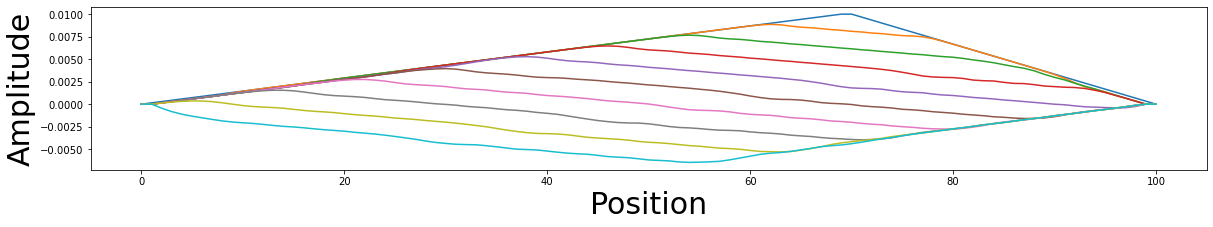

In [15]:
plt.figure(figsize=(20,3))
plt.xlabel('Position', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
for i in range(10):
    plt.plot(strum[1+i*100])

In the cell below are three for loops that index the 70th mass's position over 2.5 seconds. This is binned down to 500 data points rather than the original 500,000 for each of computation.

In [17]:
single0 = [] # Creating empty list

# Set new strum_custom definition with desired parameters
strum_custom = compute_d(sol, Nt, Nx, dt, dx, l, gamma,0,0,0,pickup_1_pos,pickup_2_pos,pickup_3_pos, height)
# In this case, the pickups are "turned off"
for i in range(5000): #Looping through 5000 times
    single0.append(strum_custom[i*100][70]) #Appending the position of the string 100*dt at site of initial pluck
    # Effectively 5000 data points of the mass position aver 2.5 seconds.

# Repeating with differnt pickups toggled "on"
strum_custom = compute_d(sol, Nt, Nx, dt, dx, l, gamma,e1,e2,e3,pickup_1_pos,pickup_2_pos,pickup_3_pos, height)
single3 = []
for i in range(5000):
    single3.append(strum_custom[i*100][70])

strum_custom = compute_d(sol, Nt, Nx, dt, dx, l, gamma,e1,0,0,pickup_1_pos,pickup_2_pos,pickup_3_pos, height)
single1 = []
for i in range(5000):
    single1.append(strum_custom[i*100][70])

The next function may already look familiar. It is the dft function fram the Day 11 Pre-Class assignemnt on Fourier Transforms.

In [18]:
# Fourier Decomp function from Day-11 Preclass Assignment
def dft(y):
    N = len(y)
    c = np.zeros(N//2 + 1, complex)
    for k in range(N//2 + 1):
        for n in range(N):
            c[k] += y[n]*np.exp(-2j*np.pi*k*n/N)
    return c

## Results and Discussion

Performing the simulation for the three cases yielded the following wave forms. From these wave forms, we can see the clear distortions present in the systems that included pickups. The single pickup system features a secondary oscillation that is clearly visible. The three pickup system also features an additional perturbation, yet its pattern appears much noisier. While we cannot know if these differences are audibly significant, they are clearly a departure from the baseline configuration featuring no pickups.

Text(0.5, 1.0, 'String position at 70th Point')

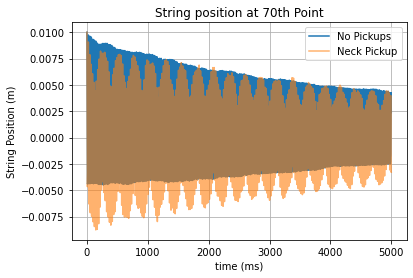

In [41]:
plt.plot(single0, label = 'No Pickups')
plt.plot(single1, label = "Neck Pickup", alpha = 0.6)
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("String Position (m)")
plt.grid()
plt.title("String position at 70th Point")

Text(0.5, 1.0, 'String position at 70th Point')

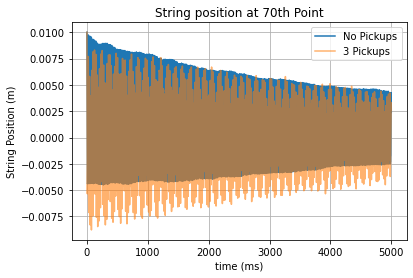

In [42]:
plt.plot(single0, label = 'No Pickups')
plt.plot(single3, label = "3 Pickups", alpha = 0.6)

plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("String Position (m)")
plt.grid()
plt.title("String position at 70th Point")

Alongside the waveforms, we can use the $dft$ function defined eearlier and pass the array into it. The resulting decompositions are shown below. It should be noted that these cells do take a long time to run. the use of Numpy FFT may benefit future implementations in this area.

Text(0.5, 1.0, 'No Pickups Fourier Decomposition')

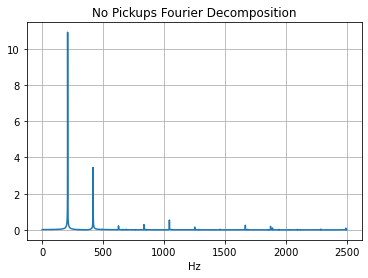

In [19]:
d0 = dft(single0)
plt.plot(np.arange(0,len(d0)),abs(d0))
d0 = list(abs(d0))
plt.xlabel("Hz")
plt.grid()
plt.title("No Pickups Fourier Decomposition")

Text(0.5, 1.0, 'Single Pickup Fourier Decomposition')

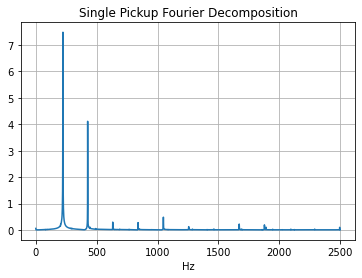

In [20]:
d1 = dft(single1)
plt.plot(np.arange(0,len(d1)),abs(d1))
d1 = list(abs(d1))
plt.xlabel("Hz")
plt.grid()
plt.title("Single Pickup Fourier Decomposition")

Text(0.5, 1.0, '3 Pickups Fourier Decomposition')

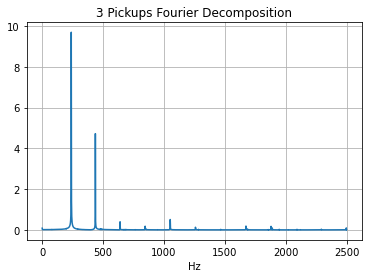

In [21]:
d3 = dft(single3)
plt.plot(np.arange(0,len(d3)),abs(d3))
d3 = list(abs(d3))
plt.xlabel("Hz")
plt.grid()
plt.title("3 Pickups Fourier Decomposition")

Below, we take the index corresponding the the max of each Fourier transform and scale them appropriately. The resulting frequencies are then neatly placed in a pandas dataframe.

In [22]:
H0 = d0.index(max(d0))*5/14
H1 = d1.index(max(d1))*5/14
H3 = d3.index(max(d3))*5/14
Hz = pd.DataFrame(np.array([[0, H0, H0-H0], [1,H1,H1-H0], [3, H3,H3-H0]]),
                   columns=['Pickup Count','Hz', 'Hz Difference'])
Hz

,Pickup Count,Hz,Hz Difference
0,0.0,74.642857,0.000000
1,1.0,79.642857,5.000000
2,3.0,85.357143,10.714286


###  Conclusion and Perspectives

   From the results, it was determined that magnetic pickups do tangible affect the sound of a plucked string, and
that there is a positive relation between pickup count and frequency. The inclusion of a single pickup raised the
frequency by 5Hz, and adding two more pickups added 10.71Hz from the baseline of zero pickups. The ”noisiness” of
the waveform also scaled with the number of pickups.<br><br>
While it remains unclear whether the distortion would be apparent strictly from the sound of the string, we must
also consider that the signal produced by a guitar pickup may incur interference from a number of sources. Each
different pickup configuration necessitates a different series of potentiometers and switches to traverse until passed
through to an amplifier or effects pedal. Each step in the circuit could introduce different perturbations that this
model cannot account for. Even light bulbs in the vicinity of guitars can cause audible interference that may dwarf
the effects of pickup configurations. From personal experience, even orienting my guitar so its pickups are exposed to
my monitor produces significant and perceptible interference.<br><br>
This model also only examine the low E string on a guitar in standard E-A-D-G-B-e tuning, commonly referred to
as the 6th string. The 6th string will measure a net force toward the center of the pickup at each amplitude whereas
the middle strings will experience more oscillation in the direction of the net force. This geometric difference may
lead to different effects for the outer-most guitar string relative to the inner strings. Strings at different tunings that
feature different tensions may also alter the effects of the pickups as magnetic dampers; alongside scale -length(l).
On a separate note, the computational methods worked surprisingly well. The NUMBA package drastically pared
down the run times of each simulation and aided in the development and estimation of the model and its parameters.
Though, different iterative methods than the Euler method I used, such as Velocity-Verlet, Euler-Cromer, or RK4,
could improve the accuracy of the experiment. Other configurations and types of pickups could also be tested. A
common single pickup system consists of a Humbucker located near the edge or bridge section of the guitar. A
Humbucker is essentially two single-coil pickups wired on opposite polarities, which may yield interesting results when
compared to a true single-coil.<br><br>
There also exists Piezo-electric pickups that directly translate the motion of the guitar string into an electric signal
via piezo electricity. Such a pickup would not experience any magnetic damping, but may fall victim to increased
frictional damping in it’s stead. Such a system would be very interesting to examine within this framework.
This model also only accounted for 1D motion of each mass on the string. Future investigations could account for
2D motion. Though a 3D model can be created, it would likely not provide any novel information as there is little
motion along the x axis that would act as the third spatial coordinate.

## References

[1] C. D. Corporation, The Anatomy Of Single Coil Pickups, (2020).<br>
[2] TDPI Forum User: Sharkfin, My Electric Guitars (2012).<br>
[3] J. Feinberg and B. Yang, Natural-frequency splitting of a guitar string caused by a non-uniform magnetic field, The Journal of the Acoustical Society of America 144, EL460 (2018), https://doi.org/10.1121/1.5080465.<br>
[4] Luke Polson, I Generated Guitar Audio in python using NUMBA (2021).<br>
[5] CS Guitars, (almost) EVERYTHING About Pickups — Too Afraid To Ask (2021).<br>
